# Multi-Peak Lorentzian Test

This notebook tests a scenario for QUENS.  Event data, including a gaussian elastic background, is randomly generated for an increasing number of lorentzian inelastic contributions.

Standard least squares fitting will be compared with EMTK routines for accuracy in these clean test cases, including a background.

There are also a bunch of good papers on the ILL IN16 web page that we could grab for real data.


## Multi Lorentzian Deconvolution

Generated 10000 samples using parameters [0.   0.02]
Adding flat background of 1000.0 points
Generated 10000 samples using parameters [0.   0.02]
Adding flat background of 1000.0 points
Width  [0.02836085]
Centre [0.01998693]
Generated 1000 samples using parameters 0.05
kde_background_subtract: estimated run time: 9 seconds


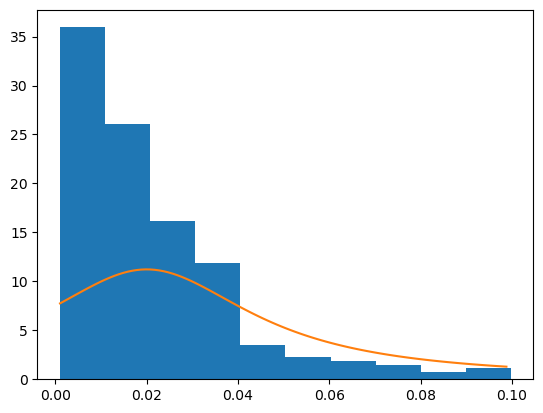

In [8]:
import emtk.quensCurves.lorentzian as lor
import emtk.curves.gaussian as gauss
from emtk.omega.omegaFunctions import kde_background_subtract

from scipy.stats import distributions

import time

import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng()

elastic = gauss.GaussianCurve()
inelastic = lor.LorentzianCurve()

xrange = np.array([0.001, 0.1])

xgrid = np.arange(xrange[0], xrange[1], 100)

rez = 0.02

# This would be something like correct, but it's too inefficient to do this
counts = 10000
#scat = int(float(counts) / 1000.0)
#flat = int(float(scat) / 10.0)

# so do this instead
scat = 1000
flat = 1000

# First we do a background measurement
elastic.generate_test_samples(np.array([0.0, rez]), xrange, counts)
elastic.generate_background(xrange, ratio=flat/counts)
background_meas = elastic.data

# Then we do sample measurements with different widths
# First contribution is the elastic line and background
elastic.generate_test_samples(np.array([0.0, rez]), xrange, counts)
elastic.generate_background(xrange, ratio=flat/counts)

# Then...

# one lorentzian
width = np.random.uniform(rez, (xrange[1]-rez)/2, 1)
centre= np.random.uniform(xrange[0], xrange[1], 1)

print("Width ", width)
print("Centre", centre)
inelastic.generate_test_samples(0.05, xrange, scat)
sample_one = np.concatenate((inelastic.data, elastic.data))
np.random.shuffle(sample_one)

cauchy1 = distributions.cauchy(loc=centre, scale=width)




# The background subtraction method just takes way too long.  
# I spent 2 days looking at scikit-learn KDE which is faster than scipy.
# scikit-learn is still going slow - how is this algorithm scaling?  
# Probably O(n^2) or something.
# This is confirmed at the bottom of this notebook.  There is now a
# timing notice, and also a warning, in kde_background_subtract, depending
# on how long the code will take to run.

#start_time = time.time()
sample_one_sub = kde_background_subtract(sample_one, background_meas)
#print("kde_background_subtraction --- time taken: %s seconds ---" % (time.time() - start_time))

s1size = sample_one_sub.size
s1min = np.amin(sample_one_sub)
s1max = np.amax(sample_one_sub)

xgrid = np.arange(s1min, s1max, (s1max-s1min)/100)
refc1 = cauchy1.pdf(xgrid)

plt.hist(sample_one_sub, density=True)
plt.plot(xgrid, refc1)

## Timing analysis of kde_background_subtract

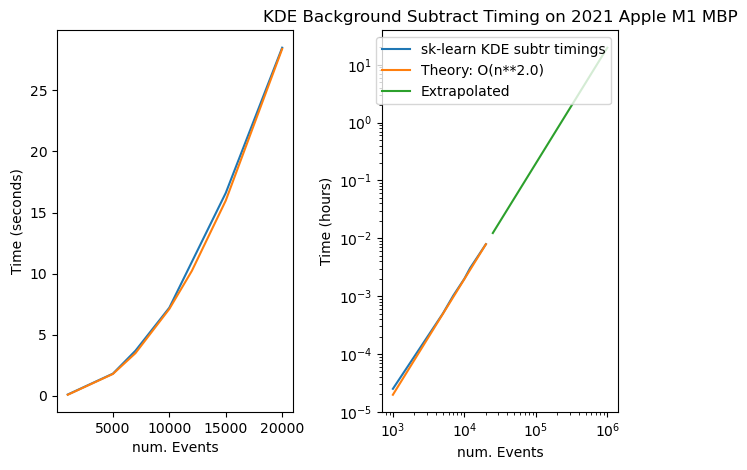

In [7]:
def sub_extrap(nn):
    return 7.1E-08*nn**2.0

size=np.array([1000, 5000, 7000, 10000, 12000, 15000, 20000])
timetaken=np.array([0.09, 1.8, 3.68, 7.2, 10.96, 16.6, 28.5])

sizeextrap=np.array([25000, 50000, 100000, 500000, 1E+06])
timeextrap=sub_extrap(sizeextrap)

fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True)

ax1.plot(size, timetaken, label='scikit-learn KDE sub timings')
ax1.plot(size, 7.1E-08*size**2.0, label='O(n**2.0)')

ax1.set_ylabel('Time (seconds)')
ax1.set_xlabel('num. Events')

plt.title('KDE Background Subtract Timing on 2021 Apple M1 MBP') 

ax2.plot(size, timetaken/60.0 / 60.0, label='sk-learn KDE subtr timings')
ax2.plot(size, 7.1E-08*size**2.0 / 60.0 / 60.0, label='Theory: O(n**2.0)')
ax2.loglog(sizeextrap, timeextrap / 60.0 / 60.0, label='Extrapolated')

ax2.set_ylabel('Time (hours)')
ax2.set_xlabel('num. Events')
plt.legend()

To do this on real data will require GPU (which we have).